In [75]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split

import os
from pprint import pprint
import io
from datetime import timedelta
from importlib import reload

from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
import pandas as pd
import math
from statsmodels.tsa.api import Holt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import (
    plot_cross_validation_metric,
    plot_forecast_component,
)


from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

In [14]:
df = pd.read_csv("temperature_data_cleaned_and_prepped.csv")

In [17]:
df["date"] = pd.to_datetime(df['date'])

In [22]:
df.drop(columns =['Unnamed: 0'], inplace=True)

In [23]:
df.head()

,date,max_temp,min_temp,avg_temp
0,1895-01-01,24.96,4.48,14.72
1,1895-02-01,27.88,2.25,15.06
2,1895-03-01,35.51,11.12,23.31
3,1895-04-01,55.49,26.22,40.86
4,1895-05-01,57.78,31.86,44.82


In [24]:
df = df.set_index('date')

In [25]:
df.head()

,max_temp,min_temp,avg_temp
date,,,
1895-01-01,24.96,4.48,14.72
1895-02-01,27.88,2.25,15.06
1895-03-01,35.51,11.12,23.31
1895-04-01,55.49,26.22,40.86
1895-05-01,57.78,31.86,44.82


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1488 entries, 1895-01-01 to 2018-12-01
Data columns (total 3 columns):
max_temp    1488 non-null float64
min_temp    1488 non-null float64
avg_temp    1488 non-null float64
dtypes: float64(3)
memory usage: 46.5 KB


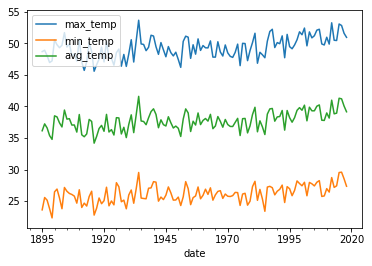

In [27]:
df.resample('Y').mean().plot()

In [45]:
aggregation = "mean"

train = df[:'2000'].resample("Y").agg(aggregation)
test = df['2000': '2019'].resample("Y").agg(aggregation)

In [46]:
print("Observations: %d" % (len(train.values) + len(test.values)))
print("Training Observations: %d" % (len(train)))
print("Testing Observations: %d" % (len(test)))

Observations: 125
Training Observations: 106
Testing Observations: 19


In [47]:
def plot_data_and_predictions(train, test, predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(train, test, predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)
        plt.title(f"{train.name}")

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(f"{train.name}\n{label}")

    plt.legend(loc='best')
    plt.show()

# Make a simple average

In [48]:
def ts_simple_average(train, test):
    yhat = pd.DataFrame(dict(actual=test))
    yhat["avg_forecast"] = train.mean()
    plot_and_eval(train, test, yhat.avg_forecast, yhat.actual)
    return yhat

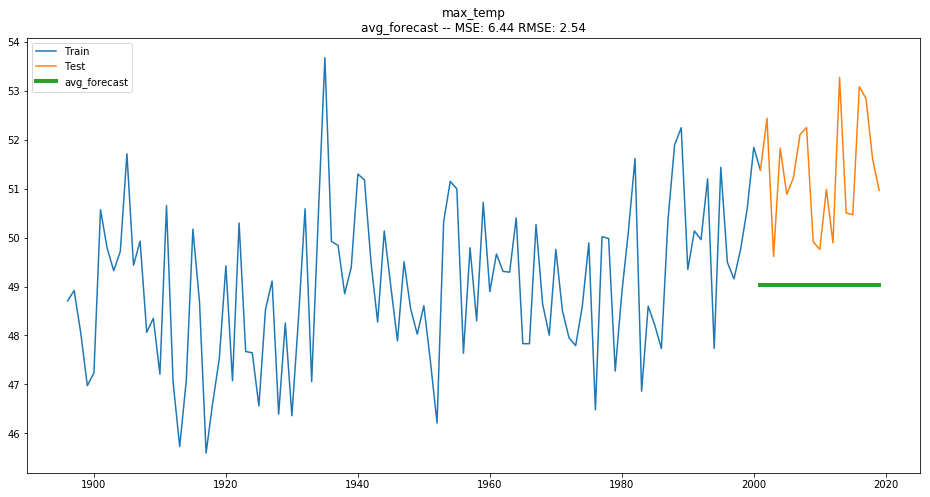

,actual,avg_forecast
date,,
2000-12-31,51.382500,49.038011
2001-12-31,52.440833,49.038011
2002-12-31,49.617500,49.038011
2003-12-31,51.831667,49.038011
2004-12-31,50.885833,49.038011
2005-12-31,51.223333,49.038011
2006-12-31,52.106667,49.038011
2007-12-31,52.253333,49.038011
2008-12-31,49.915000,49.038011


In [49]:
ts_simple_average(train['max_temp'], test['max_temp'])

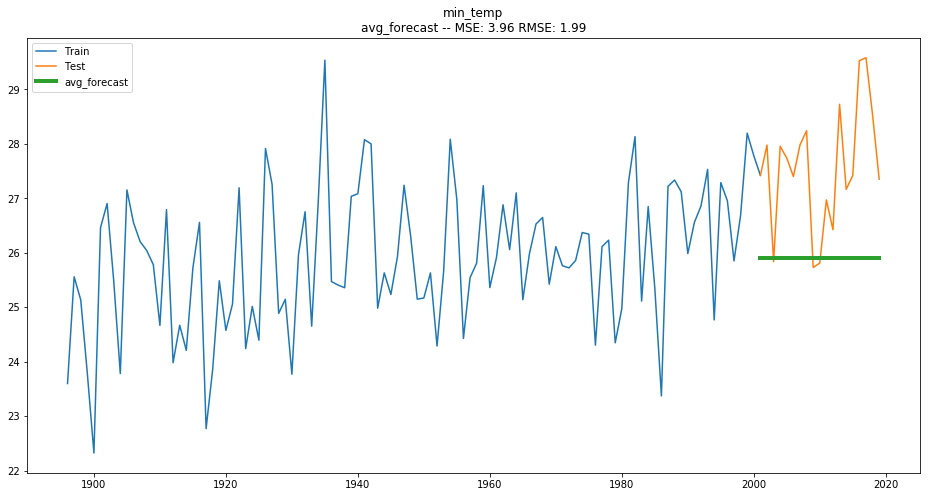

,actual,avg_forecast
date,,
2000-12-31,27.419167,25.898781
2001-12-31,27.975833,25.898781
2002-12-31,25.836667,25.898781
2003-12-31,27.953333,25.898781
2004-12-31,27.735000,25.898781
2005-12-31,27.398333,25.898781
2006-12-31,27.978333,25.898781
2007-12-31,28.239167,25.898781
2008-12-31,25.728333,25.898781


In [50]:
ts_simple_average(train['min_temp'], test['min_temp'])

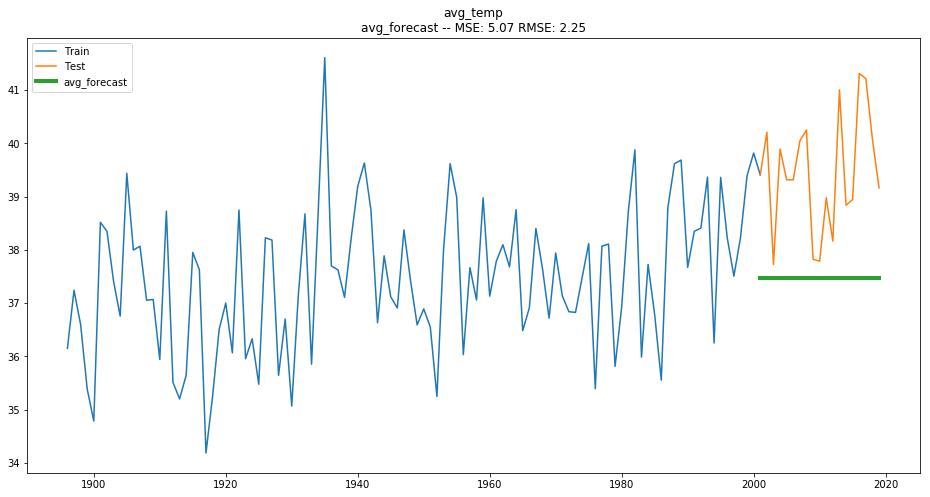

,actual,avg_forecast
date,,
2000-12-31,39.404167,37.468962
2001-12-31,40.208333,37.468962
2002-12-31,37.724167,37.468962
2003-12-31,39.891667,37.468962
2004-12-31,39.313333,37.468962
2005-12-31,39.313333,37.468962
2006-12-31,40.044167,37.468962
2007-12-31,40.249167,37.468962
2008-12-31,37.820833,37.468962


In [51]:
ts_simple_average(train['avg_temp'], test['avg_temp'])

# Make a moving average

In [52]:
def ts_moving_average(train, test, periods):
    yhat = pd.DataFrame(dict(actual=test))
    for p in periods:
        yhat[f"moving_avg_forecast_{p}"] = (
            train.rolling(p).mean().iloc[-1]
        )

    forecasts = [yhat[f"moving_avg_forecast_{p}"] for p in periods]

    plot_and_eval(train, test, forecasts, test, linewidth=2)

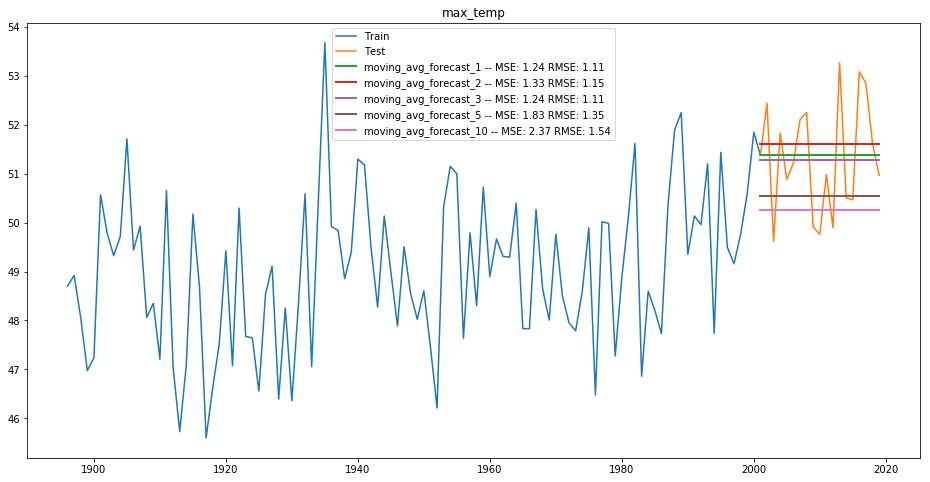

In [55]:
period_vals = [1, 2, 3, 5, 10]
ts_moving_average(train['max_temp'], test['max_temp'], period_vals)

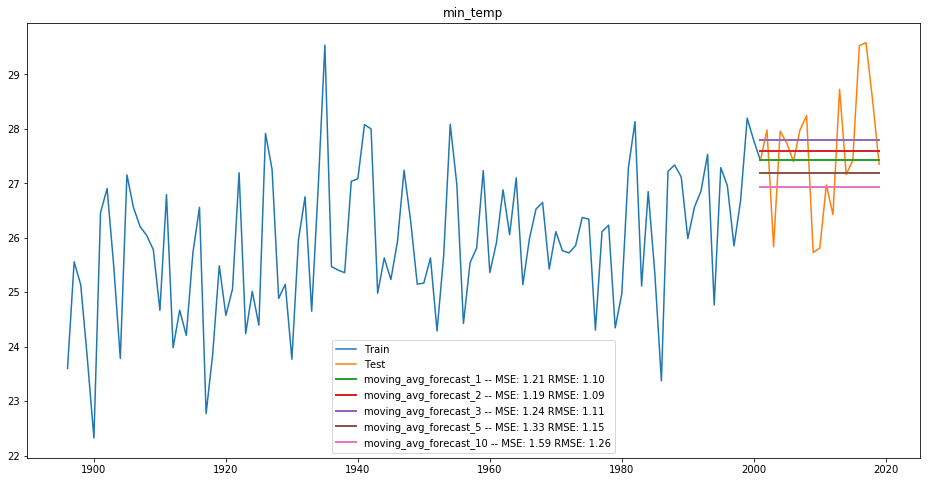

In [56]:
period_vals = [1, 2, 3, 5, 10]
ts_moving_average(train['min_temp'], test['min_temp'], period_vals)

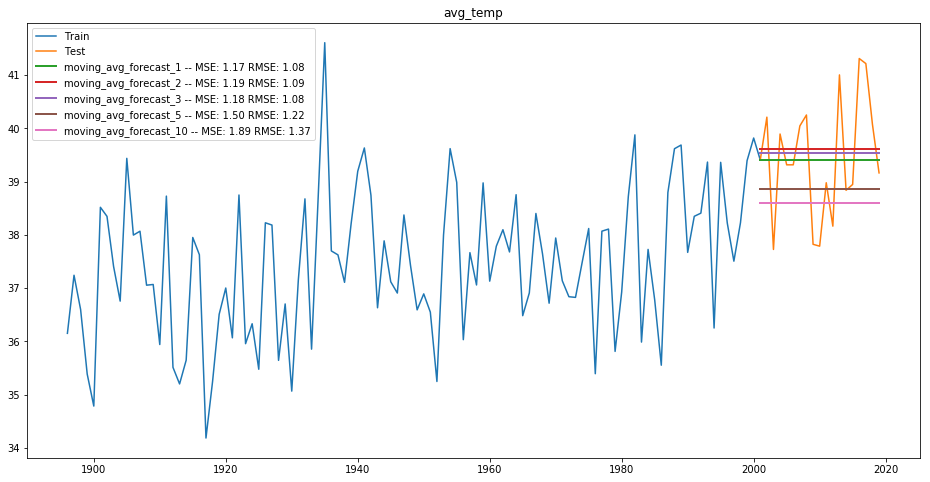

In [57]:
period_vals = [1, 2, 3, 5, 10]
ts_moving_average(train['avg_temp'], test['avg_temp'], period_vals)

# Make an ARIMA Model

In [87]:
df.reset_index(inplace=True)

In [88]:
df.head()

,date,max_temp,min_temp,avg_temp
0,1895-01-01,24.96,4.48,14.72
1,1895-02-01,27.88,2.25,15.06
2,1895-03-01,35.51,11.12,23.31
3,1895-04-01,55.49,26.22,40.86
4,1895-05-01,57.78,31.86,44.82


In [96]:
df_max = df[['date','max_temp']]
df_min = df[['date','max_temp']]
df_avg = df[['date','max_temp']]

In [97]:
df_max = df_max.set_index('date')
df_min = df_min.set_index('date')
df_avg = df_avg.set_index('date')

# Max_Temp Model

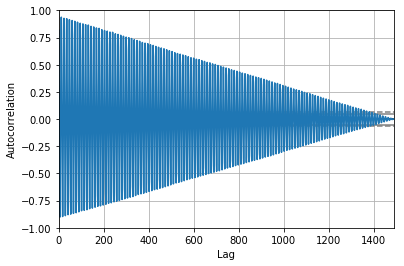

In [94]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(df_max)
plt.show()

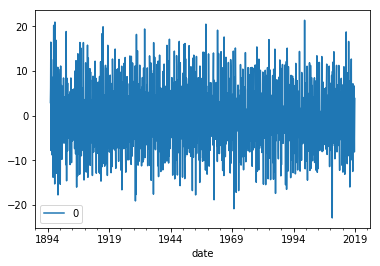

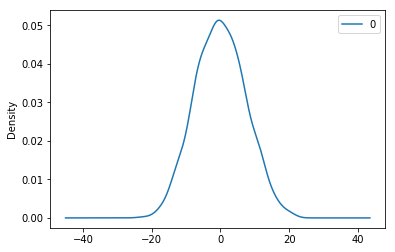

                 0
count  1487.000000
mean      0.008350
std       7.329736
min     -22.915188
25%      -5.251290
50%      -0.128049
75%       5.028870
max      21.344092


In [95]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(df_max, order=(5,1,0))
model_fit = model.fit(disp=0)
# print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [100]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1486
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5068.243
Method:                       css-mle   S.D. of innovations              7.323
Date:                Tue, 04 Jun 2019   AIC                          10150.486
Time:                        14:32:50   BIC                          10187.613
Sample:                             1   HQIC                         10164.324
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.167      0.020      0.984      -0.324       0.330
ar.L1.D.y      0.1937      0.024      7.997      0.000       0.146       0.241
ar.L2.D.y      0.3035      0.024     12.793      0.0

predicted=40.136813, expected=38.930000
predicted=29.106889, expected=32.020000
predicted=31.316964, expected=24.850000
predicted=27.840525, expected=38.610000
predicted=47.128897, expected=35.960000
predicted=45.756667, expected=53.400000
predicted=60.298451, expected=55.380000
predicted=60.094745, expected=70.500000
predicted=69.328128, expected=74.610000
predicted=76.351753, expected=68.470000
predicted=61.827187, expected=62.330000
predicted=54.574237, expected=52.650000
predicted=42.160419, expected=35.220000
predicted=29.331981, expected=27.820000
predicted=24.996466, expected=24.980000
predicted=26.897023, expected=27.930000
predicted=35.887472, expected=41.360000
predicted=53.156197, expected=47.480000
predicted=56.362622, expected=52.140000
predicted=55.322233, expected=66.330000
predicted=65.419997, expected=72.210000
predicted=70.926893, expected=70.210000
predicted=68.384863, expected=62.920000
predicted=55.532770, expected=54.840000
predicted=44.169566, expected=29.500000


predicted=25.330102, expected=32.000000
predicted=37.470271, expected=29.080000
predicted=38.284494, expected=43.430000
predicted=51.998200, expected=50.020000
predicted=55.656621, expected=62.440000
predicted=67.183424, expected=69.370000
predicted=71.480460, expected=75.290000
predicted=71.577705, expected=77.500000
predicted=73.912480, expected=68.180000
predicted=60.843311, expected=47.640000
predicted=36.917427, expected=31.320000
predicted=19.183874, expected=30.990000
predicted=27.619317, expected=30.340000
predicted=39.214985, expected=35.850000
predicted=48.652579, expected=37.990000
predicted=45.991672, expected=44.440000
predicted=46.595160, expected=53.190000
predicted=55.449340, expected=63.390000
predicted=65.414218, expected=72.900000
predicted=75.257051, expected=76.440000
predicted=75.321117, expected=63.070000
predicted=55.771398, expected=46.530000
predicted=33.069037, expected=38.500000
predicted=27.516805, expected=31.300000
predicted=29.983640, expected=25.120000


predicted=36.380741, expected=40.370000
predicted=50.904215, expected=43.810000
predicted=50.372368, expected=51.190000
predicted=54.657249, expected=63.930000
predicted=65.683566, expected=77.020000
predicted=77.889666, expected=76.300000
predicted=76.877697, expected=68.680000
predicted=60.837400, expected=52.740000
predicted=39.222490, expected=36.540000
predicted=24.160738, expected=31.100000
predicted=27.572249, expected=33.350000
predicted=39.336200, expected=32.610000
predicted=43.330621, expected=47.280000
predicted=57.123928, expected=53.470000
predicted=60.421766, expected=57.290000
predicted=59.259650, expected=70.430000
predicted=70.263194, expected=79.320000
predicted=78.076221, expected=76.960000
predicted=75.937349, expected=68.720000
predicted=61.426908, expected=49.140000
predicted=35.756510, expected=41.110000
predicted=31.176844, expected=29.640000
predicted=28.208612, expected=30.060000
predicted=35.060810, expected=32.340000
predicted=42.129892, expected=41.470000


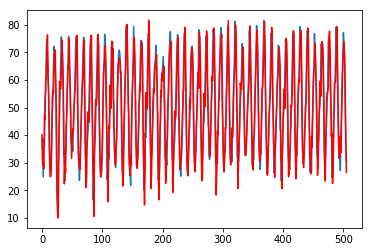

In [99]:
from sklearn.metrics import mean_squared_error

X = df_max.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()